In [ ]:
%%capture
!pip install torchtext==0.6.0

In [ ]:
import random, math, time, os

import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator
from torchtext.data.metrics import bleu_score

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def seed_everything(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
seed_everything(3407)

In [ ]:
%%capture
!python -m spacy download en
!python -m spacy download de

In [ ]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [ ]:
tokenized = spacy_en.tokenizer("I am penultimate year computer science student in hku.")

for i, token in enumerate(tokenized):
    print(f"Index {i}: {token.text}")

Index 0: I
Index 1: am
Index 2: penultimate
Index 3: year
Index 4: computer
Index 5: science
Index 6: student
Index 7: in
Index 8: hku
Index 9: .


In [ ]:
def tokenize_de(text):
    return [token.text for token in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

In [ ]:
SRC = Field(tokenize=tokenize_de, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)
TRG = Field(tokenize=tokenize_en, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)

In [ ]:
train_dataset, valid_dataset, test_dataset = Multi30k.splits(exts=(".de", ".en"), fields=(SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 570kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 175kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 165kB/s]


In [ ]:
len(train_dataset.examples), len(valid_dataset.examples), len(test_dataset.examples)

(29000, 1014, 1000)

In [ ]:
vars(train_dataset.examples[100])

{'src': ['männliches',
  'kleinkind',
  'in',
  'einem',
  'roten',
  'hut',
  ',',
  'das',
  'sich',
  'an',
  'einem',
  'geländer',
  'festhält',
  '.'],
 'trg': ['toddler',
  'boy',
  'in',
  'a',
  'red',
  'hat',
  'holding',
  'on',
  'to',
  'some',
  'railings',
  '.']}

In [ ]:
SRC.build_vocab(train_dataset, min_freq=2)
TRG.build_vocab(train_dataset, min_freq=2)

print(f"len(SRC): {len(SRC.vocab)}")
print(f"len(TRG): {len(TRG.vocab)}")

len(SRC): 7855
len(TRG): 5893


In [ ]:
print(TRG.vocab.stoi["abcabc"]) # Non-existing word: 0
print(TRG.vocab.stoi[TRG.pad_token]) # padding: 1
print(TRG.vocab.stoi["<sos>"]) # <sos>: 2
print(TRG.vocab.stoi["<eos>"]) # <eos>: 3
print(TRG.vocab.stoi["hello"])
print(TRG.vocab.stoi["world"])

0
1
2
3
4112
1752


In [ ]:
BATCH_SIZE = 128
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    device=device)

In [ ]:
batch = next(iter(train_iterator))
src, trg = batch.src, batch.trg
print(f"First batch size: {src.shape}")
print(f"First batch size: {trg.shape}")

for i in range(src.shape[1]):
    print(f"Index {i}: {src[0][i].item()}") # [Seq_num, Seq_len]

First batch size: torch.Size([128, 27])
First batch size: torch.Size([128, 28])
Index 0: 2
Index 1: 73
Index 2: 9
Index 3: 17
Index 4: 147
Index 5: 84
Index 6: 9
Index 7: 8
Index 8: 1565
Index 9: 7483
Index 10: 5516
Index 11: 4
Index 12: 3
Index 13: 1
Index 14: 1
Index 15: 1
Index 16: 1
Index 17: 1
Index 18: 1
Index 19: 1
Index 20: 1
Index 21: 1
Index 22: 1
Index 23: 1
Index 24: 1
Index 25: 1
Index 26: 1


In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    # hidden_dim : embedding dimension of word
    # n_head : number of heads
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__()
        
        assert(hidden_dim % n_heads == 0), "hidden_dim size needs to be div by n_heads"
        
        # embedding dimension
        self.hidden_dim = hidden_dim 
        # the number of heads : Number of different attention concepts
        self.n_heads = n_heads
        # Embedding dimension at each head
        self.head_dim = hidden_dim // n_heads

        # Basically, dimension is converted from hidden_dim to the key dimension.
        # Since the dimension of the key is hidden_dim, it is converted from hidden_dim to hidden_dim.
        ## FC layer to be applied to query
        self.fc_q = nn.Linear(hidden_dim, hidden_dim) 
        ## FC layer to be applied to key
        self.fc_k = nn.Linear(hidden_dim, hidden_dim)
        ## FC layer to be applied to value
        self.fc_v = nn.Linear(hidden_dim, hidden_dim)
        
        self.fc_o = nn.Linear(hidden_dim, hidden_dim)
        
        self.dropout = nn.Dropout(dropout_ratio)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask=None):
        
        batch_size = query.shape[0]
        
        # query : [batch_size, query_len, hidden_dim] → Q : [batch_size, query_len, hidden_dim]
        Q = self.fc_q(query)
        # key : [batch_size, key_len, hidden_dim] → K : [batch_size, key_len, hidden_dim]
        K = self.fc_k(key)
        # value : [batch_size, value_len, hidden_dim] → V : [batch_size, value_len, hidden_dim]
        V = self.fc_v(value)
        
        # Seperate hidden_dim to n_heads*head_dim
        # Learn n_heads kinds of different attention concepts.
        
        # Q : [batch_size, query_len, hidden_dim]
        ## → Q : [batch_size, query_len, n_heads, head_dim]
        ### → Q : [batch_size, n_heads, query_len, head_dim]
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # K : [batch_size, key_len, hidden_dim]
        ## → K : [batch_size, key_len, n_heads, head_dim]
        ### → K : [batch_size, n_heads, key_len, head_dim]
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        # V : [batch_size, value_len, hidden_dim]
        ## → V : [batch_size, value_len, n_heads, head_dim]
        ### → V : [batch_size, n_heads, value_len, head_dim]
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        # Calculate attention energe
        # Q : [batch_size, n_heads, query_len, head_dim]
        # K.permute : [batch_size, n_heads, head_dim, key_len]
        
        # energy : [batch_size, n_heads, query_len, key_len]
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        if mask != None:
            # Fill in the part where the mask value is 0 with a very small value.
            energy = energy.masked_fill(mask==0, -1e10)
        
        # calculate attention score : probability about each data(ex.word)
        # We get attention score based on key_len.
        # attention : [batch_size, n_heads, query_len, key_len]
        attention = torch.softmax(energy, dim=-1)
        
        # attention : [batch_size, n_heads, query_len, key_len]
        # V : [batch_size, n_heads, value_len, head_dim]
        # x : [batch_size, n_heads, query_len, head_dim] (∵ key_len = value_len in this self-attention)
        x = torch.matmul(self.dropout(attention), V)
        
        # x : [batch_size, n_heads, query_len, head_dim]
        # → x : [batch_size, query_len, n_heads, head_dim]
        x = x.permute(0, 2, 1, 3).contiguous()
        
        # x : [batch_size, query_len, hidden_dim]
        x = x.reshape(batch_size, -1, self.hidden_dim)
        
        # x : [batch_size, query_len, hidden_dim]
        x = self.fc_o(x)
        
        return x, attention

In [ ]:
class PositionwiseFeedForwardLayer(nn.Module):
    # hidden_dim : embedding dimension of a word
    # pf_dim : inner embedding dimension in feed forward layer
    # dropout_ratio
    def __init__(self, hidden_dim, pf_dim, dropout_ratio):
        super().__init__()
        
        self.fc_1 = nn.Linear(hidden_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hidden_dim)
        
        self.dropout = nn.Dropout(dropout_ratio)
        
    def forward(self, x):
        # x : [batch_size, seq_len, hidden_dim]
        # → x : [batch_size, seq_len, pf_dim]
        x = self.dropout(torch.relu(self.fc_1(x)))
        # → x : [batch_size, seq_len, hidden_dim]
        x = self.fc_2(x)
        
        return x

In [ ]:
class EncoderLayer(nn.Module):
    # Dimension of input and output are same.
    # Encoder of transformer uses multiple times encoder layer by using characteristics above.
    # set mask value 0 to <pad> token
    
    # hidden_dim : embedding dimension of a word
    # n_heads : the number of heads = the number of scaled-dot product attention
    # pf_dim : inner embedding dimension in feed-forward layer
    # dropout_ratio : dropout ratio
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedForwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # self-attention + ffn
    def forward(self, src, src_mask):
        # src: [batch_size, src_len, hidden_dim]
        # src_mask: [batch_size, src_len]

        # self attention
        # forward(self, query, key, value, mask=None):
        _src, _ = self.self_attention(src, src, src, src_mask)

        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        # position-wise feedforward
        _src = self.positionwise_feedforward(src)

        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        return src

In [ ]:
class Encoder(nn.Module):
    # set mask value 0 to <pad> token. (<pad> token filled up after <eos>)
    # implemented positional encoding with nn.Embedding not sin, cos function. 

    # input_dim : one hot encoding dimension of a word
    # hidden_dim : embedding dimension of input_dim
    # n_layers : the number of encoder layer
    # n_heads : the number of heads = the number of scaled-dot product attention
    # pf_dim : inner embedding dimension in feed-forward layer
    # dropout_ratio : dropout ratio
    # max_length : maximum number of words in sentence
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, src, src_mask):

        # src: [batch_size, src_len]
        # src_mask: [batch_size, src_len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, src_len]

        # source embedding + position embedding
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        # src: [batch_size, src_len, hidden_dim]

        # pass xN encoder layers
        for layer in self.layers:
            src = layer(src, src_mask)

        # src: [batch_size, src_len, hidden_dim]

        return src 

In [ ]:
class DecoderLayer(nn.Module):
    # Dimension of input and output are same.
    # Decoder of transformer uses multiple times encoder layer by using characteristics above.
    # Decoder layer use two multi-head attention layer
    # set mask value 0 to <pad> token
    # Each word in the target sentence uses a mask to make it impossible to know what the next word is (see only the previous word).
    
    # hidden_dim : embedding dimension of input_dim
    # n_heads : the number of heads = the number of scaled-dot product attention
    # pf_dim : inner embedding dimension in feed-forward layer
    # dropout_ratio : dropout ratio
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedForwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg: [batch_size, trg_len, hidden_dim]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]
        
        # self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        # trg: [batch_size, trg_len, hidden_dim]
            
        # encoder attention
        # forward(self, query, key, value, mask=None):
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        # trg: [batch_size, trg_len, hidden_dim]
        
        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        # trg: [batch_size, trg_len, hidden_dim]
        # attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [ ]:
class Decoder(nn.Module):
    # set mask value 0 to <pad> token. (<pad> token filled up after <eos>)
    # implemented positional encoding with nn.Embedding not sin, cos function. 
    
    # output_dim : one-hot encoding dimension of a word
    # hidden_dim : embedding dimension of a word
    # n_layers : the number of encoding layers
    # n_heads : the number of heads = the number of scaled-dot product attention
    # pf_dim : inner embedding dimension in feed-forward layer
    # dropout_ratio : dropout ratio
    # max_length : maximum number of words in sentence
    
    # set mask value 0 to <pad> token
    # Each word in the target sentence uses a mask to make it impossible to know what the next word is (see only the previous word).
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, trg_len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        # trg: [batch_size, trg_len, hidden_dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        output = self.fc_out(trg)

        # output: [batch_size, trg_len, output_dim]

        return output, attention

In [ ]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    # set mask value as zero to <pad> token of src
    def make_src_mask(self, src):
        
        # src : [batch_size, src_len]
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        
        # src_mask : [batch_size, 1, 1, src_len]
        return src_mask
    
    # Each word in the target word uses a mask to make it impossible to know what the next word is (see only the previous word).
    def make_trg_mask(self, trg):
        
        # trg : [batch_size, trg_len]
        
        '''
        mask example
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0 
        1 1 1 0 0
        1 1 1 0 0
        '''
        
        # trg_pad_mask : [batch_size, 1, 1, trg_len]
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        trg_len = trg.shape[1]
        
        '''
        mask example
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 1 0
        1 1 1 1 1
        '''
        
        # trg_sub_mask : [trg_len, trg_len]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        # trg_mask : [batch_size, 1, trg_len, trg_len] (broadcast)
        trg_mask = trg_pad_mask & trg_sub_mask
        
        return trg_mask
    
    def forward(self, src, trg):
        # src : [batch_size, src_len]
        # trg : [batch_size, trg_len]
        
        
        # src_mask : [batch_size, 1, 1, src_len]
        src_mask = self.make_src_mask(src)
        # trg_mask : [batch_size, 1, trg_len, trg_len]
        trg_mask = self.make_trg_mask(trg)
        
        # encoder_src : [batch_size, src_len, hidden_dim]
        encoder_src = self.encoder(src, src_mask)

        # output : [batch_size, trg_len, output_dim]
        # attention : [batch_size, n_heads, trg_len, src_len]
        
        output, attention = self.decoder(trg, encoder_src, trg_mask, src_mask)
        
        return output, attention

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HIDDEN_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

# Transformer 객체 선언
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
model

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(7855, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedForwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
 

In [ ]:
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg #trg = [batch size, trg len]
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1]) #output = [batch size, trg len - 1, output dim]
               
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim) #output = [batch size * trg len - 1, output dim]
        trg = trg[:,1:].contiguous().view(-1) #trg = [batch size * trg len - 1]
                
        loss = criterion(output, trg)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg #trg = [batch size, trg len]
 
            output, _ = model(src, trg[:,:-1]) #output = [batch size, trg len - 1, output dim]
        
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim) #output = [batch size * trg len - 1, output dim]
            trg = trg[:,1:].contiguous().view(-1) #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time
import math
import random

N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time() 
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        print(f'Best epoch{epoch+1} with loss {valid_loss}')
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_german_to_english.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

Best epoch1 with loss 3.1282200813293457
Epoch: 01 | Time: 0m 15s
	Train Loss: 4.114 | Train PPL: 61.195
	Validation Loss: 3.128 | Validation PPL: 22.833
Best epoch2 with loss 2.6114568412303925
Epoch: 02 | Time: 0m 15s
	Train Loss: 3.033 | Train PPL: 20.768
	Validation Loss: 2.611 | Validation PPL: 13.619
Best epoch3 with loss 2.3467289209365845
Epoch: 03 | Time: 0m 15s
	Train Loss: 2.619 | Train PPL: 13.719
	Validation Loss: 2.347 | Validation PPL: 10.451
Best epoch4 with loss 2.184619292616844
Epoch: 04 | Time: 0m 14s
	Train Loss: 2.344 | Train PPL: 10.426
	Validation Loss: 2.185 | Validation PPL: 8.887
Best epoch5 with loss 2.0596296340227127
Epoch: 05 | Time: 0m 14s
	Train Loss: 2.130 | Train PPL: 8.414
	Validation Loss: 2.060 | Validation PPL: 7.843
Best epoch6 with loss 1.9906220734119415
Epoch: 06 | Time: 0m 14s
	Train Loss: 1.956 | Train PPL: 7.070
	Validation Loss: 1.991 | Validation PPL: 7.320
Best epoch7 with loss 1.918952226638794
Epoch: 07 | Time: 0m 14s
	Train Loss: 1.81

In [ ]:
model.load_state_dict(torch.load('transformer_german_to_english.pt'))

<All keys matched successfully>

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
example_idx = 10

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print(f'Source sentence: {src}')
print(f'Target sentence: {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print("Model result:", " ".join(translation))

Source sentence: ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
Target sentence: ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']
Model result: a mother and her son enjoying a beautiful day outdoors . <eos>


In [ ]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=10)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [ ]:
example_idx = 10

src = vars(train_dataset.examples[example_idx])['src']
trg = vars(train_dataset.examples[example_idx])['trg']

print(f'Source sentence: {src}')
print(f'Target sentence: {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

Source sentence: ['eine', 'ballettklasse', 'mit', 'fünf', 'mädchen', ',', 'die', 'nacheinander', 'springen', '.']
Target sentence: ['a', 'ballet', 'class', 'of', 'five', 'girls', 'jumping', 'in', 'sequence', '.']
predicted trg = ['a', 'girl', 'with', 'five', '<unk>', 'jumping', 'in', 'the', 'air', '.', '<eos>']


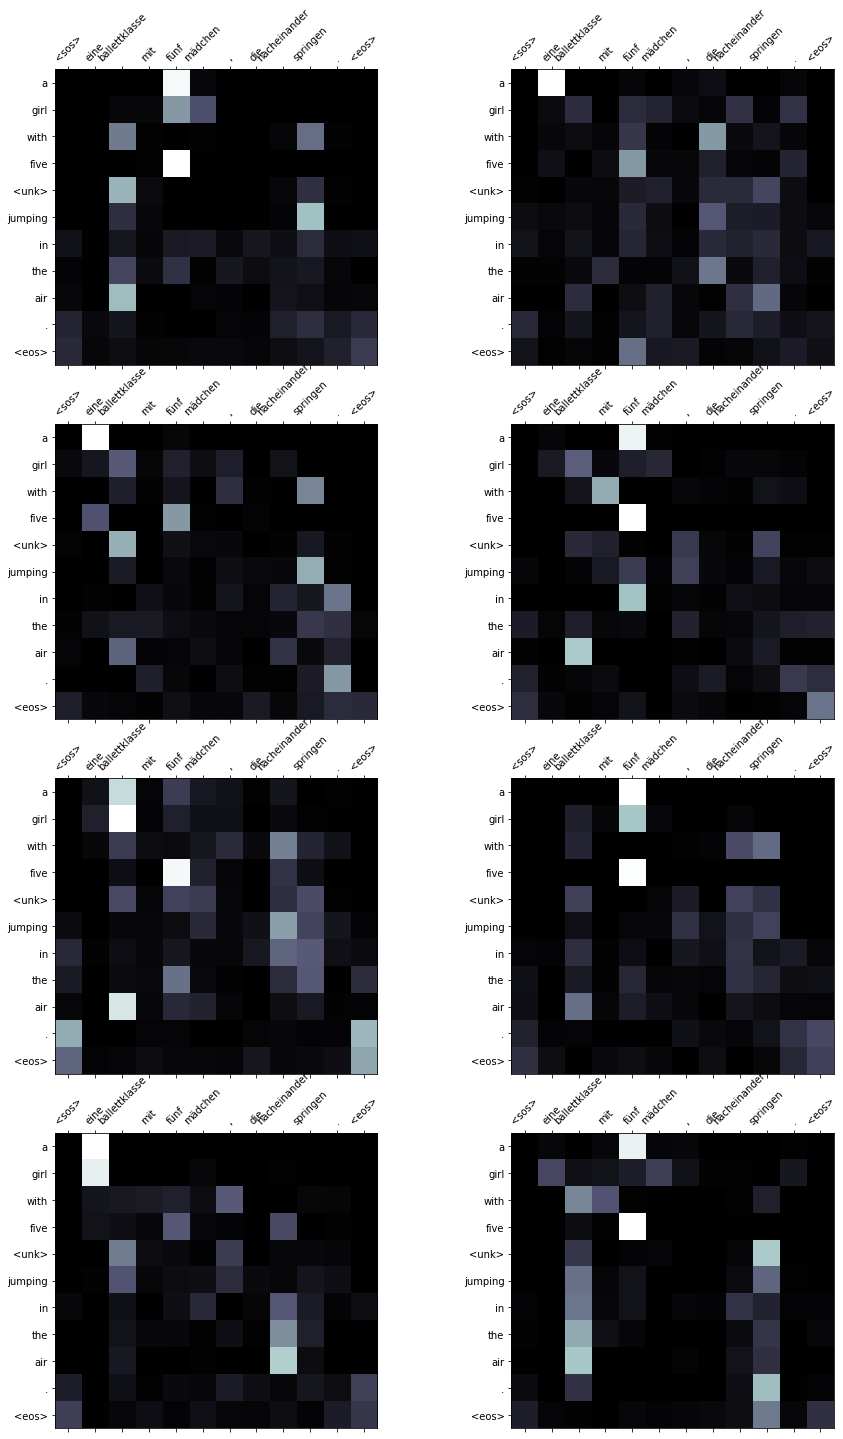

In [ ]:
display_attention(src, translation, attention)

In [ ]:
def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_dataset, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 30.19


# **References**


*   https://gaussian37.github.io/dl-concept-transformer/#output-softmax-1
*   https://colab.research.google.com/github/metamath1/ml-simple-works/blob/master/transformer/annotated_transformer.ipynb?fbclid=IwAR0r_K7fSfmyk5vhQ-McJKGFj4Hj5A_ccoDRYiZh7nCy9MoD-WvTgCPbkik#scrollTo=N26U07Vmze0L
*   https://charon.me/posts/pytorch/pytorch_seq2seq_6/#decoder
*   https://colab.research.google.com/github/ndb796/







